<a href="https://colab.research.google.com/github/gcunhase/ML-Notebook/blob/master/models/conv_autoencoder_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder

## 1. Libraries

*Installing and importing necessary packages*

*Working with **Python 3.6** and **PyTorch 1.0.1** *

In [13]:
import sys
import os
!{sys.executable} -m pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from timeit import default_timer as timer
import numpy as np

print("PyTorch version: {}".format(torch.__version__))
cudnn_enabled = torch.backends.cudnn.enabled
print("CuDNN enabled" if cudnn_enabled else "CuDNN disabled")

PyTorch version: 1.0.1.post2
CuDNN enabled


## 2. Variables

In [24]:
# Make reproducible run
torch.manual_seed(1)

# Settable parameters
params = {'root': './data/',
          'results_dir': './results/',
          'model_type': 'convolutional',  # simple, convolutional
          'batch_size': 128,
          'epochs': 30,
          'save_ep': 1,
          'lr': 0.0001,
          'weight_decay': 5e-4,  # 1e-10,
          'num_classes': 10,
          'input_height': 28,
          'input_width': 28,
          'use_cuda': True,
         }

# GPU usage
print("GPU: {}, number: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
device = torch.device('cuda') if params['use_cuda'] and torch.cuda.is_available() else torch.device('cpu')

# Ensure results directory exists
if not os.path.exists(params['results_dir']):
    os.mkdir(params['results_dir'])

GPU: True, number: 1


## 3. Dataset

In [25]:
# Get train and test datasets
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(
    root=params['root'],  # directory where the data is or where it will be saved
    train=True,  # train dataset
    download=True,  # download if you don't have it
    transform=trans)  # converts PIL.image or np.ndarray to torch.FloatTensor of shape (C, H, W) and normalizes from (0.0, 1.0)
mnist_test = datasets.MNIST(root=params['root'], train=False, download=True, transform=trans)  # transforms.ToTensor()
print("MNIST Train {}, Test {}".format(len(mnist_train), len(mnist_test)))

# Dataloader: mini-batch during training
mnist_train_dataloader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=params['batch_size'], shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=params['batch_size'], shuffle=True)

MNIST Train 60000, Test 10000


## 4. Model

`Conv2d`: *convolution in encoder*

`ConvTranspose2d`: *deconvolution in decoder*

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # bs, 32, 28, 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),  # bs, 64, 28, 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2), # bs, 64, 14, 14
            nn.Conv2d(64, 128, 3, padding=1),  # bs, 128, 14, 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2), # bs, 128, 7, 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # bs, 64, 14, 14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), # bs, 32, 14, 14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # bs, 1, 28, 28
            nn.ReLU(),
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

## 5. Train

epoch [1/30], loss:0.0063
epoch [2/30], loss:0.0037
epoch [3/30], loss:0.0027
epoch [4/30], loss:0.0018
epoch [5/30], loss:0.0013
epoch [6/30], loss:0.0011
epoch [7/30], loss:0.0009
epoch [8/30], loss:0.0009
epoch [9/30], loss:0.0008
epoch [10/30], loss:0.0008
epoch [11/30], loss:0.0006
epoch [12/30], loss:0.0006
epoch [13/30], loss:0.0010
epoch [14/30], loss:0.0005
epoch [15/30], loss:0.0006
epoch [16/30], loss:0.0005
epoch [17/30], loss:0.0005
epoch [18/30], loss:0.0004
epoch [19/30], loss:0.0004
epoch [20/30], loss:0.0007
epoch [21/30], loss:0.0004
epoch [22/30], loss:0.0004
epoch [23/30], loss:0.0004
epoch [24/30], loss:0.0003
epoch [25/30], loss:0.0004
epoch [26/30], loss:0.0004
epoch [27/30], loss:0.0004
epoch [28/30], loss:0.0004
epoch [29/30], loss:0.0005
epoch [30/30], loss:0.0003


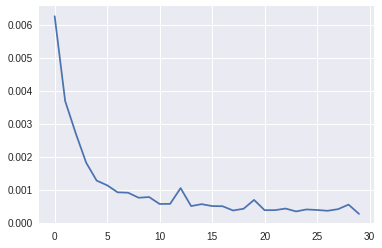

In [27]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

loss_arr = []
ep_arr = []
model.zero_grad()
for epoch in range(params['epochs']):
    for i, data in enumerate(mnist_train_dataloader):
        img, _ = data  # bs, 1, 28, 28
        img = img.to(device)
        img = Variable(img).to(device)
        
        # Forward
        output = model(img)
        loss = criterion(output, img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % params['save_ep'] == 0:
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, params['epochs'], loss.cpu().data))
      loss_arr.append(loss.cpu().data)
      ep_arr.append(epoch)
      
torch.save(model.state_dict(), params['results_dir'] + 'conv_autoencoder.pth')
plt.plot(ep_arr, loss_arr)
plt.show()

## 6. Test

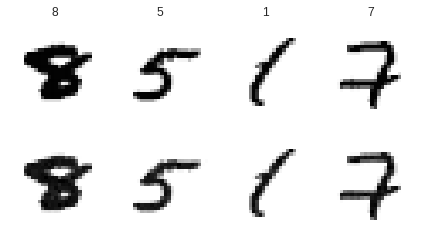

In [43]:
model.eval()

examples = enumerate(mnist_test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

ncols = 4

fig, axes = plt.subplots(nrows=2, ncols=ncols)
for i, ax in enumerate(axes.flat):
  # Original images
  if i < ncols:
    idx = i
    img = example_data[idx][0]
  else:  # Reconstructed images
    idx = i-ncols
    img = example_data[idx][0]
    img = img.unsqueeze(0)
    img = img.unsqueeze(0)
    img = img.to(device)
  
    output = model(img)
    pic = output.cpu().data
    pic = pic.view(params['input_height'], params['input_width'])
    img = pic
    
  ax.imshow(img)
  if i < ncols:
    ax.set_title('{}'.format(example_targets[idx]))
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()